In [23]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [24]:
case_title = 'endo invalid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+1, 1.5+1+1+0.05+1]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+1, 1.5+0.033*4+1+0.05+1]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None # 0.3
    lowpass = None

    EP_lists, RT_lists = fe.pipeline_session_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False, detrend=1)

    if 'slow' in case:
        sessions_slow = EP_lists
        rts_slow = RT_lists
    else:
        sessions_fast = EP_lists
        rts_fast = RT_lists


In [25]:
eegs_list = [sessions_fast, sessions_slow]
rts_list = [rts_fast, rts_slow]
session_names = ["sham before", "sham after", "real before", "real after"]
freq_band_names = ["theta", "alpha", "beta", "gamma"]
region_names = ["frontal", "central", "parietal", "occipital", "temporal"] # , "all"]
stage_names_endo = ["fixation", "cue", "wait", "response", "until response"]
stage_names_exo = ["fixation", "wait", "response", "until response"]
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
endo_fast_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5+1+0.5+0.05, 1.5+1+0.5+0.05+0.3], [0, 1.5+1+0.5+0.05]]
endo_slow_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5+1+1+0.05, 1.5+1+1+0.05+0.3], [0, 1.5+1+1+0.05]]
exo_fast_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+0.5], [1.5+0.033*4+0.5+0.05, 1.5+0.033*4+0.5+0.05+0.3], [0, 1.5+0.033*4+0.5+0.05]]
exo_slow_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+1], [1.5+0.033*4+1+0.05, 1.5+0.033*4+1+0.05+0.3], [0, 1.5+0.033*4+1+0.05]]

if 'endo' in case_title:
    stages_list = [endo_fast_stages, endo_slow_stages]
    stage_names = stage_names_endo
else:
    stages_list = [exo_fast_stages, exo_slow_stages]
    stage_names = stage_names_exo
bp_rt = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'group_id', 'band power', 'reaction time'])

In [26]:
for i, sessions in enumerate(eegs_list):
    rts = rts_list[i]
    stage_list = stages_list[i]
    for j, session_name in enumerate(session_names):
        session_eeg = sessions[j]
        session_rt = rts[j]
        # print(session_name)
        for group_id in range(9):
            # print(group_id)
            eeg = session_eeg[group_id]
            rt = session_rt[group_id]
            for trial in range(eeg.shape[0]):
                trial_data = eeg[trial,:,:]
                for k, stage in enumerate(stage_list):
                    stage_start = int(stage[0]*fs)
                    stage_end = int(stage[1]*fs)
                    psds, freqs = mne.time_frequency.psd_array_multitaper(trial_data[:,stage_start:stage_end], fs, fmin=1, fmax=51, verbose=False)
                    for l, freq_band in enumerate(freq_bands):
                        bp = fe.band_power(psds, freqs, freq_band)
                        for region in region_names:
                            channels_dict = fe.pick_cortex(region)
                            channel_names_list = list(channels_dict.keys())
                            channels = [channels_dict[key]-1 for key in channel_names_list]
                            bp_region = np.nanmean(bp[channels])
                            new_row = pd.DataFrame({
                                'stage': [stage_names[k]],
                                'band': [freq_band_names[l]],
                                'region': [region],
                                'session': [session_name],
                                'group_id': [group_id],
                                'band power': [bp_region],
                                'reaction time': [rt[trial]]
                            })
                            bp_rt = pd.concat([bp_rt, new_row], ignore_index=True)
bp_rt
# 11 min 32 s for endo or exo
# 42 s for endo invalid
# 6 min 7.7 s for endo valid

,stage,band,region,session,group_id,band power,reaction time
0,fixation,theta,frontal,sham before,0,4.379796e-09,0.42679
1,fixation,theta,central,sham before,0,6.614999e-09,0.42679
2,fixation,theta,parietal,sham before,0,3.735611e-09,0.42679
3,fixation,theta,occipital,sham before,0,4.138496e-09,0.42679
4,fixation,theta,temporal,sham before,0,4.619048e-09,0.42679
...,...,...,...,...,...,...,...
35695,until response,gamma,frontal,real after,8,9.010658e-10,0.35396
35696,until response,gamma,central,real after,8,7.586944e-10,0.35396
35697,until response,gamma,parietal,real after,8,9.954150e-10,0.35396
35698,until response,gamma,occipital,real after,8,8.650689e-10,0.35396


In [27]:
bp_rt_session = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'band power', 'reaction time'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            for session in session_names:
                for group_id in range (9):
                    bp_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['band power'].mean()
                    rt_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['reaction time'].mean()
                    new_row = pd.DataFrame({
                        'stage': [stage],
                        'band': [band],
                        'region': [region],
                        'session': [session],
                        'band power': [bp_mean],
                        'reaction time': [rt_mean]
                    })
                    bp_rt_session = pd.concat([bp_rt_session, new_row], ignore_index=True)
bp_rt_session
# 5 m 23.3 s for endo or exo
# 1 m 2.9 s for endo invalid
# 4 m 9.4 s for endo valid

,stage,band,region,session,band power,reaction time
0,fixation,theta,frontal,sham before,4.897839e-09,0.396738
1,fixation,theta,frontal,sham before,1.751666e-09,0.272630
2,fixation,theta,frontal,sham before,6.385192e-09,0.326898
3,fixation,theta,frontal,sham before,9.784518e-09,0.292787
4,fixation,theta,frontal,sham before,8.157503e-08,0.304247
...,...,...,...,...,...,...
3595,until response,gamma,temporal,real after,4.161968e-09,0.303678
3596,until response,gamma,temporal,real after,2.781248e-09,0.292421
3597,until response,gamma,temporal,real after,1.700934e-09,0.236993
3598,until response,gamma,temporal,real after,1.388771e-09,0.350270


In [28]:
def remove_max_val(arr1, arr2):
    max_idx = np.argmax(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

def remove_min_val(arr1, arr2):
    max_idx = np.argmin(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

def remove_outliers(case_title, bps, rts):
    if case_title == 'endo valid':
        bps, rts = remove_max_val(bps, rts)
        bps, rts = remove_min_val(bps, rts)
        rts, bps = remove_max_val(rts, bps)
        rts, bps = remove_min_val(rts, bps)

    elif case_title == 'endo invalid':
        bps, rts = remove_max_val(bps, rts)
        bps, rts = remove_min_val(bps, rts)
        rts, bps = remove_max_val(rts, bps)
        rts, bps = remove_min_val(rts, bps)

        bps, rts = remove_max_val(bps, rts)
        bps, rts = remove_min_val(bps, rts)
        rts, bps = remove_max_val(rts, bps)
        rts, bps = remove_min_val(rts, bps)

    elif case_title == 'exo valid':
        bps, rts = remove_max_val(bps, rts)
        bps, rts = remove_min_val(bps, rts)
        rts, bps = remove_max_val(rts, bps)
        rts, bps = remove_min_val(rts, bps)

    return bps, rts

ccp_table = pd.DataFrame(columns=['stage', 'band', 'region', 'cc', 'p'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            bps = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]['band power'].values
            rts = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]['reaction time'].values
            bps, rts = remove_outliers(case_title, bps, rts)
            cc, p = stats.pearsonr(bps, rts)
            new_row = pd.DataFrame({
                'stage': [stage],
                'band': [band],
                'region': [region],
                'cc': [cc],
                'p': [p]
            })
            ccp_table = pd.concat([ccp_table, new_row], ignore_index=True)


ccp_table.sort_values(by=['cc'], ascending=False).head(15)

,stage,band,region,cc,p
39,cue,gamma,temporal,0.402623,0.033654
99,until response,gamma,temporal,0.395046,0.037474
79,response,gamma,temporal,0.381465,0.045181
1,fixation,theta,central,0.378899,0.046770
59,wait,gamma,temporal,0.372942,0.050627
75,response,gamma,frontal,0.329002,0.087358
19,fixation,gamma,temporal,0.316509,0.100808
95,until response,gamma,frontal,0.312112,0.105894
94,until response,beta,temporal,0.309529,0.108969
55,wait,gamma,frontal,0.303855,0.115956


In [29]:
# ## not by session, but by trial?
# ccp_table = pd.DataFrame(columns=['stage', 'band', 'region', 'cc', 'p'])
# for stage in stage_names:
#     for band in freq_band_names:
#         for region in region_names:
#             bps = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region)]['band power']
#             rts = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region)]['reaction time']
#             cc, p = stats.pearsonr(bps, rts)
#             new_row = pd.DataFrame({
#                 'stage': [stage],
#                 'band': [band],
#                 'region': [region],
#                 'cc': [cc],
#                 'p': [p]
#             })
#             ccp_table = pd.concat([ccp_table, new_row], ignore_index=True)

# ccp_table.sort_values(by=['cc'], ascending=False).head(10)

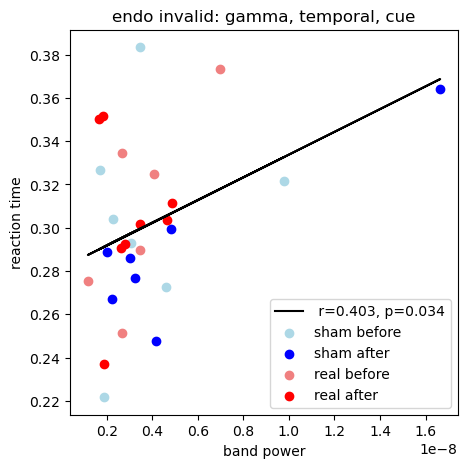

In [30]:
stage = "cue"
band = "gamma"
region = "temporal"
bp_rt_roi = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]
bps, rts = bp_rt_roi['band power'].values, bp_rt_roi['reaction time'].values
bps, rts = remove_outliers(case_title, bps, rts)
matched_rows = pd.DataFrame()

for bp_value, rt_value in zip(bps, rts):
    mask = (bp_rt_roi['band power'] == bp_value) & (bp_rt_roi['reaction time'] == rt_value)
    matched_rows = pd.concat([matched_rows, bp_rt_roi[mask]])


bp_sb, rt_sb = matched_rows[matched_rows['session']=='sham before']['band power'].values, matched_rows[matched_rows['session']=='sham before']['reaction time'].values
bp_sa, rt_sa = matched_rows[matched_rows['session']=='sham after']['band power'].values, matched_rows[matched_rows['session']=='sham after']['reaction time'].values
bp_rb, rt_rb = matched_rows[matched_rows['session']=='real before']['band power'].values, matched_rows[matched_rows['session']=='real before']['reaction time'].values
bp_ra, rt_ra = matched_rows[matched_rows['session']=='real after']['band power'].values, matched_rows[matched_rows['session']=='real after']['reaction time'].values
colors = ['lightblue', 'blue', 'lightcoral', 'red']


# Concatenate all the updated band power and reaction time arrays for regression
bp = np.concatenate((bp_sb, bp_sa, bp_rb, bp_ra))
rt = np.concatenate((rt_sb, rt_sa, rt_rb, rt_ra))

# Recalculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(bp, rt)
line = slope*bp+intercept

# Update the plot
plt.figure(figsize=(5,5))
plt.plot(bp, line, 'k', label=' r='+str(round(r_value, 3))+', p='+str(round(p_value, 3)))

plt.scatter(bp_sb, rt_sb, label='sham before', color=colors[0])
plt.scatter(bp_sa, rt_sa, label='sham after', color=colors[1])
plt.scatter(bp_rb, rt_rb, label='real before', color=colors[2])
plt.scatter(bp_ra, rt_ra, label='real after', color=colors[3])

plt.legend()
plt.title(case_title+': '+band+', '+region+', '+stage)
plt.xlabel("band power")
plt.ylabel("reaction time")
plt.show()